# Constraint Satisfaction Problems

This notebook serves as a supporting material for Chapter 6 **Constraint Satisfaction Problems**. In this notebook, we demonstrate how the [csp package][1] can be used to solve problems that can be formulated as CSPs. We use **factored representation** for the states in a CSP. We will see that by deviating from the notion of atomic states, we can use general purpose inference techniques and search heuristics to solve any CSP. Hence, a CSP solver can be used to solve any problem once it has been formulated as a CSP. Let's begin by loading the `aima-core` jar file.

[1]: https://github.com/aimacode/aima-java/tree/AIMA3e/aima-core/src/main/java/aima/core/search/csp

In [1]:
%classpath add jar ../out/artifacts/aima_core_jar/aima-core.jar

# Defining constraint Satisfaction Problems 

Let's begin with formally defining a CSP. Later, we will dive into the code repository and explore the CSP class.

As per the textbook, a constraint satisfaction problem consists of three components, $X$, $D$, and $C$:
* $X$ is a set of [variables][1], $\{X_1,...,X_n\}$.
* $D$ is a set of [domains][2], $\{D_1,...,D_n\}$, one for each variable.
* $C$ is a set of [constraints][3] that specify allowable combinations of values.


Each domain $D_i$ consists of a set of allowable values, $\{v_1,...,v_k\}$ for variable $X_i$. Each constraint $C_i$ consists of a pair $<scope,rel>$, where $scope$ is a tuple of variables that participate in the constraint and $rel$ is a relation that defines the values that those variables can take on. A relation can be represented as an explicit list of all tuples of values that satisfy the constraint, or as an abstract relation that supports two operations: testing if a tuple is a member of the relation and enumerating the members of the relation.

Let's take a look at the [CSP class][4] in the code repository and then we will move on to formally define our first problem.

[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Variable.java
[2]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Domain.java
[3]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/Constraint.java
[4]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/CSP.java

In [9]:
package aima.core.search.csp;

import java.util.ArrayList;
import java.util.Collections;
import java.util.Hashtable;
import java.util.List;

public class CSP<VAR extends Variable, VAL> implements Cloneable {

    private List<VAR> variables;
    private List<Domain<VAL>> domains;
    private List<Constraint<VAR, VAL>> constraints;

    /**
     * Lookup, which maps a variable to its index in the list of variables.
     */
    private Hashtable<Variable, Integer> varIndexHash;
    /**
     * Constraint network. Maps variables to those constraints in which they
     * participate.
     */
    private Hashtable<Variable, List<Constraint<VAR, VAL>>> cnet;

    /**
     * Creates a new CSP.
     */
    public CSP() {
        variables = new ArrayList<>();
        domains = new ArrayList<>();
        constraints = new ArrayList<>();
        varIndexHash = new Hashtable<>();
        cnet = new Hashtable<>();
    }

    /**
     * Creates a new CSP.
     */
    public CSP(List<VAR> vars) {
        this();
        vars.forEach(this::addVariable);
    }

    /**
     * Adds a new variable only if its name is new.
     */
    protected void addVariable(VAR var) {
        if (!varIndexHash.containsKey(var)) {
            Domain<VAL> emptyDomain = new Domain<>(Collections.emptyList());
            variables.add(var);
            domains.add(emptyDomain);
            varIndexHash.put(var, variables.size() - 1);
            cnet.put(var, new ArrayList<>());
        } else {
            throw new IllegalArgumentException("Variable with same name already exists.");
        }
    }

    public List<VAR> getVariables() {
        return Collections.unmodifiableList(variables);
    }

    public int indexOf(Variable var) {
        return varIndexHash.get(var);
    }

    public void setDomain(VAR var, Domain<VAL> domain) {
        domains.set(indexOf(var), domain);
    }

    public Domain<VAL> getDomain(Variable var) {
        return domains.get(varIndexHash.get(var));
    }

    /**
     * Replaces the domain of the specified variable by new domain, which
     * contains all values of the old domain except the specified value.
     */
    public boolean removeValueFromDomain(VAR var, VAL value) {
        Domain<VAL> currDomain = getDomain(var);
        List<VAL> values = new ArrayList<>(currDomain.size());
        for (VAL v : currDomain)
            if (!v.equals(value))
                values.add(v);
        if (values.size() < currDomain.size()) {
            setDomain(var, new Domain<>(values));
            return true;
        }
        return false;
    }

    public void addConstraint(Constraint<VAR, VAL> constraint) {
        constraints.add(constraint);
        for (VAR var : constraint.getScope())
            cnet.get(var).add(constraint);
    }

    public boolean removeConstraint(Constraint<VAR, VAL> constraint) {
        boolean result = constraints.remove(constraint);
        if (result)
            for (VAR var : constraint.getScope())
                cnet.get(var).remove(constraint);
        return result;
    }

    public List<Constraint<VAR, VAL>> getConstraints() {
        return constraints;
    }

    /**
     * Returns all constraints in which the specified variable participates.
     */
    public List<Constraint<VAR, VAL>> getConstraints(Variable var) {
        return cnet.get(var);
    }

    /**
     * Returns for binary constraints the other variable from the scope.
     *
     * @return a variable or null for non-binary constraints.
     */
    public VAR getNeighbor(VAR var, Constraint<VAR, VAL> constraint) {
        List<VAR> scope = constraint.getScope();
        if (scope.size() == 2) {
            if (var.equals(scope.get(0)))
                return scope.get(1);
            else if (var.equals(scope.get(1)))
                return scope.get(0);
        }
        return null;
    }

    /**
     * Returns a copy which contains a copy of the domains list and is in all
     * other aspects a flat copy of this.
     */
    @SuppressWarnings("unchecked")
    public CSP<VAR, VAL> copyDomains() {
        CSP<VAR, VAL> result;
        try {
            result = (CSP<VAR, VAL>) clone();
            result.domains = new ArrayList<>(domains.size());
            result.domains.addAll(domains);
        } catch (CloneNotSupportedException e) {
            throw new UnsupportedOperationException("Could not copy domains.");
        }
        return result;
    }
}

aima.core.search.csp.CSP

The class takes generics `VAR` and `VAL` for the type of variables and the values they can take respectively. The data structures used in the class include:
* `List<VAR> variables`: The list of all variables in the CSP
* `List<Domain<VAL>> domains`: The corresponding domains of the variables
* `List<Constraint<VAR, VAL>> constraints`: The list of different constraints in the CSP
* `Hashtable<Variable, Integer> varIndexHash`: A lookup table that stores the index of variable $X_i$ in the `variables` list
* `Hashtable<Variable, List<Constraint<VAR, VAL>>> cnet`: This is an adjacency list representation of the **constraint hypergraph**

The class also contains the following useful methods:
* `CSP()`: constructor that initializes an empty CSP
* `CSP(List<VAR> vars)`: constructor that initializes the CSP with given variables
* `void addVariable(VAR var)`: Adds a new variable to the CSP
* `List<VAR> getVariables()`: Lists all variables currently in the CSP
* `void setDomain(VAR var, Domain<VAL> domain)`: Used to specify the *domain* of the variable *var*
* `Domain<VAL> getDomain(Variable var)`: Returns the domain of the variable *var*
* `boolean removeValueFromDomain(VAR var, VAL value)`: Modifies the domain of the variable *var* by removing a particular value from it
* `void addConstraint(Constraint<VAR, VAL> constraint)`: Adds a constraint to the CSP
* `boolean removeConstraint(Constraint<VAR, VAL> constraint)`: Removes a constraint from the CSP
* `List<Constraint<VAR, VAL>> getConstraints()`: Returns all constraints in the CSP
* `List<Constraint<VAR, VAL>> getConstraints(Variable var)`: Returns all constraints that concern with the variable *var*
* `VAR getNeighbor(VAR var, Constraint<VAR, VAL> constraint)`: Returns the second variable $neighbor$ in the constraint for a binary constraint $<(var,neighbor),rel>$

## Example Problems 

### Map coloring
This simple problem is taken from the textbook (3rd edition: Section 6.1.1, Page 207). The task is simple. We need to color the regions in the australia map such that no two region sharing a boundary have the same color.

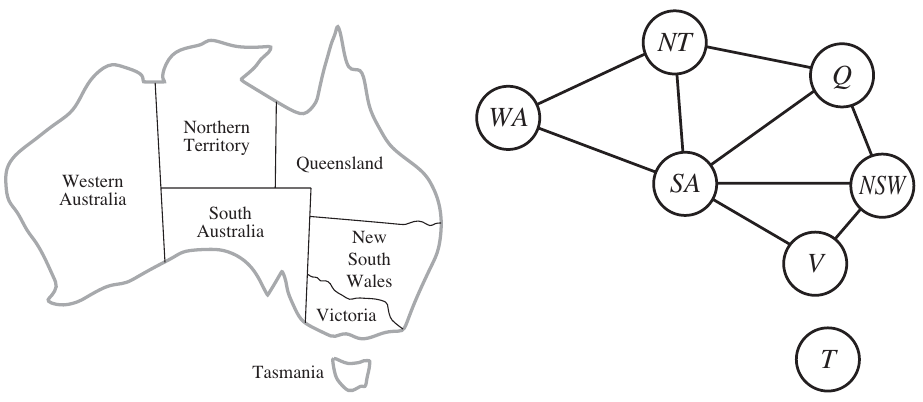

Only constraint we will be using in the map coloring CSP is the *Alldiff* constraint. *Alldiff* constraint is a **global constraint** (constraint involving arbitrary number of variables) that restricts the variables to take the same value. For e.g., let $A$, $B$ and $C$ be variables with the same domain $D_A=D_B=D_C=\{1,2,5,6,7\}$. Then, the constraint *Alldiff*$(A,B,C)$ can be enumerated as 
    $$\{(1,2,5),(1,2,6),(1,2,7),(1,5,6),(1,5,7),(1,6,7),(2,5,6),(2,5,7),(2,6,7),(5,6,7)\}$$

The map coloring problem can be represented as a CSP as follows:
* **Variables:** Each region in the map represents a variable in the CSP. For keeping things simple, we will name the variables with the initials of the region (e.g., Northern Territory -> NT). Thus, $X = \{WA,NT,Q,NSW,V,SA,T\}$
* **domains:** The domain of a variable includes various colors that the corresponding region can be colored with. In this case, all the variables have the same domain $D_i = \{red,green,blue\}$
* **constraints:** Since any set of regions having a common boundary can't be of same color, we introduce the constraints *Alldiff*$(WA,NT,SA)$, *Alldiff*$(NT,SA,Q)$, *Alldiff*$(SA,Q,NSW)$ and *Alldiff*$(SA,NSW,V)$. These *Alldiff* constraints can be simplified to binary [*NotEqualConstraint*][1] constraints (as shown in the constraint graph above), but we will proceed with *Alldiff* as the *NotEqualConstraint* is already implemented in the code repository.
[1]: https://github.com/aimacode/aima-java/blob/AIMA3e/aima-core/src/main/java/aima/core/search/csp/examples/NotEqualConstraint.java